# Simulation Demonstration

This notebook demonstrates the construction of a control system using the node based model, and the simulation of the system.

In [1]:
import sys
import torch
sys.path.append('../')

# Reference Signal Node

In [2]:
from humancompatible.interconnect.simulators.nodes.reference import ReferenceSignal
refsig = ReferenceSignal(name="r")
refsig.set_reference_signal(0.5)

# Aggregator Node
Aggregator nodes are the only nodes that can accept a many to one connection. They will combine these signals into a single signal.

In [3]:
class AggregatorLogic:
    def __init__(self):
        self.list = []
        
    def forward(self, tensors):
        if type(tensors) is not list:
            tensors = [tensors]
        self.list = tensors
        return torch.sum(torch.stack([torch.sum(t) for t in self.list])).unsqueeze(dim=0)
        

In [4]:
X = torch.tensor([1.0], requires_grad=True)
Y = torch.tensor([2.5], requires_grad=True)
Z = torch.tensor([1.2], requires_grad=True)
al = AggregatorLogic()
res = al.forward([Y,Z])
al.list, res

([tensor([2.5000], requires_grad=True), tensor([1.2000], requires_grad=True)],
 tensor([3.7000], grad_fn=<UnsqueezeBackward0>))

In [5]:
from humancompatible.interconnect.simulators.nodes.aggregator import Aggregator
agg1 = Aggregator(name="A1", logic=AggregatorLogic())
agg2 = Aggregator(name="A2", logic=AggregatorLogic())

# Controller Node

In [6]:
from humancompatible.interconnect.simulators.nodes.controller import Controller

class PiControllerLogic:
    def __init__(self, kappa=0.5, alpha=0.1, sp=0.0):
        self.tensors = {"S": torch.tensor([0.0], requires_grad=True),
                        "kappa": torch.tensor([kappa], requires_grad=True, dtype=torch.float),
                        "alpha": torch.tensor([alpha], requires_grad=True, dtype=torch.float),
                        "sp": torch.tensor([sp], requires_grad=True, dtype=torch.float),
                        "e": torch.tensor([0.0], requires_grad=True),
                        "e_prev": torch.tensor([0.0], requires_grad=True),
                        "pi_prev": torch.tensor([0.0], requires_grad=True)
                        }
        self.variables = ["S"]

    def forward(self, values):
        self.tensors["S"] = torch.tensor([values["S"]], requires_grad=True, dtype=torch.float)
        self.tensors["e"] = self.tensors["sp"] - self.tensors["S"]
        result = (self.tensors["pi_prev"] + self.tensors["kappa"] * (
                    self.tensors["e"] - self.tensors["alpha"] * self.tensors["e_prev"]))
        self.tensors["e_prev"] = self.tensors["e"]
        self.tensors["pi_prev"] = result
        return result

cont = Controller(name="C", logic=PiControllerLogic(sp=150000.0))
        

# Population Node

In [7]:
from humancompatible.interconnect.simulators.nodes.population import Population

class AgentLogic1:
    def __init__(self):
        self.tensors = {"x": torch.tensor([0.0], requires_grad=True),
                        "startThreshold": torch.tensor([-80.0], requires_grad=True),
                        "endThreshold": torch.tensor([80.0], requires_grad=True)}
        self.variables = ["x"]
        
    def forward(self, values):
        self.tensors["x"] = torch.tensor([values["x"]], requires_grad=True, dtype=torch.float)
        result = torch.where(
            torch.tensor([self.tensors["x"] < self.tensors["startThreshold"]]),
            torch.tensor([0.0],requires_grad=True),
            torch.where(
                torch.tensor([self.tensors["x"] > self.tensors["startThreshold"]]),
                torch.tensor([1.0], requires_grad=True),
                (1 + torch.cos(torch.pi * (self.tensors["x"] - self.tensors["endThreshold"]) / (self.tensors["startThreshold"] - self.tensors["endThreshold"]))) / 2
            )
        )
        return result

class AgentLogic2:
    def __init__(self):
        self.tensors = {"x": torch.tensor([0.0], requires_grad=True),
                        "startThreshold": torch.tensor([-20.0], requires_grad=True),
                        "endThreshold": torch.tensor([20.0], requires_grad=True)}
        self.variables = ["x"]
        
    def forward(self, values):
        self.tensors["x"] = torch.tensor([values["x"]], requires_grad=True, dtype=torch.float)
        result = torch.where(
            torch.tensor([self.tensors["x"] < self.tensors["startThreshold"]]),
            torch.tensor([0.0]),
            torch.where(
                torch.tensor([self.tensors["x"] > self.tensors["startThreshold"]]),
                torch.tensor([1.0]),
                (1 + torch.cos(torch.pi * (self.tensors["x"] - self.tensors["endThreshold"]) / (self.tensors["startThreshold"] - self.tensors["endThreshold"]))) / 2
            )
        )
        return result
    
pop1 = Population(name="P1",
                  logic=AgentLogic1(),
                  number_of_agents=100000,
                  positive_response=1,
                  negative_response=0)

pop2 = Population(name="P2",
                  logic=AgentLogic2(),
                  number_of_agents=100000,
                  positive_response=1,
                  negative_response=0)

# Delay Node

In [8]:
from humancompatible.interconnect.simulators.nodes.delay import Delay
delay = Delay(name="Z", time=1)

# Filterer Node

In [9]:
from humancompatible.interconnect.simulators.nodes.filterer import Filterer

class FiltererLogic:
    def __init__(self):
        self.tensors = {"S": torch.tensor([0.0], requires_grad=True),
                        "K": torch.tensor([3.0], requires_grad=True),}
        self.variables = ["S"]
    
    def forward(self, values):
        self.tensors["S"] = torch.tensor([values["S"]], requires_grad=True, dtype=torch.float)
        result = (self.tensors["S"] + 1) * self.tensors["K"]
        return result
    
fil = Filterer(name="F", logic=FiltererLogic())

In [10]:
l = FiltererLogic()
vals = {"S": X}
res = l.forward(vals)
print(res)

tensor([6.], grad_fn=<MulBackward0>)


# Simulation

In [11]:
from humancompatible.interconnect.simulators.simulation import Simulation
sim = Simulation()

### Creating the system

In [12]:
sim.system.add_nodes([refsig, agg1, cont, pop1, agg2, delay, fil])
sim.system.connect_nodes(refsig, agg1)
sim.system.connect_nodes(agg1, cont)
sim.system.connect_nodes(cont,pop1)
# sim.system.connect_nodes(cont,pop2)
sim.system.connect_nodes(pop1,agg2)
# sim.system.connect_nodes(pop2,agg2)
sim.system.connect_nodes(agg2, delay)
sim.system.connect_nodes(delay, fil)
sim.system.connect_nodes(fil, agg1)

sim.system.set_start_node(refsig)
sim.system.set_checkpoint_node(agg1)

### Rendering the system graph

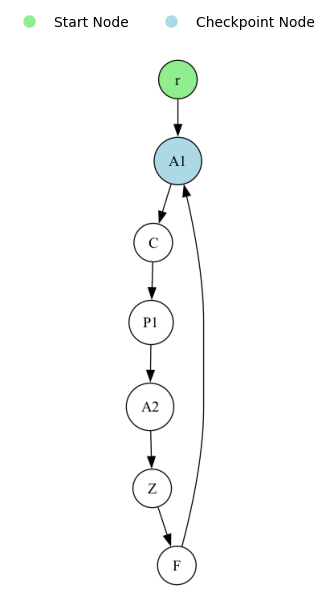

In [13]:
sim.plot.render_graph()

In [14]:
sim.system.run(100,True)

Running Control System: 101it [00:00, 1014.24it/s]             

NODE: r
   INPUT: []
   OUTPUT: tensor([0.5000], requires_grad=True)
NODE: A1
   INPUT: [tensor([0.5000], requires_grad=True), []]
   OUTPUT: tensor([0.5000], grad_fn=<UnsqueezeBackward0>)
Checkpoint: Iteration 0
NODE: C
   INPUT: [tensor([0.5000], grad_fn=<UnsqueezeBackward0>)]
   OUTPUT: tensor([74999.7500], grad_fn=<AddBackward0>)
NODE: P1
   INPUT: [tensor([74999.7500], grad_fn=<AddBackward0>)]
   OUTPUT: tensor([1., 1., 1.,  ..., 1., 1., 1.], grad_fn=<WhereBackward0>)
NODE: A2
   INPUT: [tensor([1., 1., 1.,  ..., 1., 1., 1.], grad_fn=<WhereBackward0>)]
   OUTPUT: tensor([100000.], grad_fn=<UnsqueezeBackward0>)
NODE: Z
   INPUT: [tensor([100000.], grad_fn=<UnsqueezeBackward0>)]
   OUTPUT: tensor([100000.], grad_fn=<UnsqueezeBackward0>)
NODE: F
   INPUT: [tensor([100000.], grad_fn=<UnsqueezeBackward0>)]
   OUTPUT: tensor([300003.], grad_fn=<MulBackward0>)
NODE: A1
   INPUT: [tensor([0.5000], requires_grad=True), tensor([300003.], grad_fn=<MulBackward0>)]
   OUTPUT: tensor([300003.50

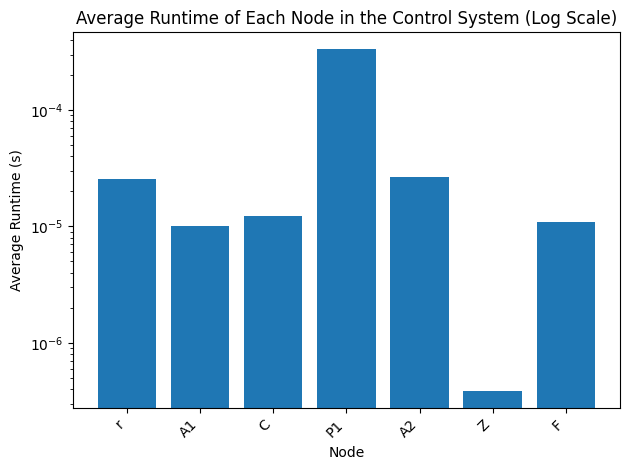

In [15]:
sim.plot.runtimes()